# **Elementary Trading Algorithms and Backtesting (WORK IN PROGRESS)**

## **Contents**
1) [Introduction](#Introduction)
2) [Moving Average Strategy](#Moving-Average-Strategy)
3) [Bollinger Bands Strategy](#Bollinger-Bands-Strategy)
4) [Fibonacci Retracement Strategy](#Fibonacci-Retracement-Strategy)
5) [Credits](#Credits)

## **Introduction**
The purpose of this project is to formulate and backtest some basic trading algorithms using Python, in order to evaluate their performance. The `time`, `datetime`, `numpy`, `scipy`, `pandas`, `matplotlib`, `seaborn`, `yfinance`, `pypfopt`, `riskfolio` and `warnings` libraries are imported. Moreover, the plot styles are adjusted for aesthetic reasons and some warnings are ignored for readability (as of the time of conception, all warnings encountered in this project were warnings about deprecated features that are not used in this project).

In [93]:
import time as tm
import datetime as dt
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pypfopt as ppf
import riskfolio as rsk
import warnings as wrn

palette = sns.color_palette("viridis_r", as_cmap = True)
sns.set_style(style = "whitegrid", rc = {"font.family" : "Times New Roman", "font.weight" : "bold"})
wrn.simplefilter(action = 'ignore', category = FutureWarning)

A couple of remarks are in order:
- The benchmark used to evaluate the performance of the trading algorithms is the buy-and-hold strategy over a specified time frame;
- The metric used to evaluate the performance of the trading algorithms is the cumulative return generated by the trading strategies;
- Monthly portfolio rebalancing will be applied at the beginning of each month via inverse-volatility weighting;
- Other metrics of interest which are calculated include annualized expected return, annualized volatility, annualized Sharpe ratio, Value-at-Risk (VaR) and Expected Shortfall (ES), and;
- No part of this project is intended to be financial advice, and the reader is kindly implored not to interpret it as such. On the other hand, the reader is strongly encouraged to make informed decisions and be aware of the risks involved with trading in the financial markets.

Two functions, `strategy_trading_signals`, `strategy_metrics` and `strategy_backtest`, which respectively visualise the trading signals of, display key performance metrics of and display the cumulative returns of a trading strategy of interest and of the buy-and-hold strategy as a benchmark, are defined in the code cells below:

### **Function for Visualising Strategy Trading Signals**

In [94]:
def strategy_trading_signals(strategy_name, df):
    """
    Visualise the trading signals of a trading strategy of interest.

    Parameters
    ----------
    strategy_name : str
        A string representing the name of the trading strategy whose trading signals are to be visualised.
    df : pandas.core.frame.DataFrame
        A pandas DataFrame object representing the general performance metrics of the trading strategy
    
    Returns
    -------
    matplotlib.figure.Figure
        A matplotlib Figure object illustrating the trading signals of the trading strategy of interest.
    """
    assert strategy_name in ["Moving Average", "Bollinger Bands", "Fibonacci Retracement"], "Variable strategy_name must be one of \"Moving Average\", \"Bollinger Bands\" and \"Fibonacci Retracement\"."
    if strategy_name == "Moving Average":
        fig, ax = plt.subplots(figsize = (16, 9), dpi = 300)
        for column, color, style, label in zip(
            ["Shorter-Term", "Portfolio", "Longer-Term"],
            ["red", "black", "green"],
            ["--", "-", "--"],
            ["Shorter-Term Moving Average", "Portfolio Value", "Longer-Term Moving Average"]
        ):
            sns.lineplot(data = df, x = "Date", y = column, color = color, linestyle = style, label = label, linewidth = 0.85)
        plt.plot(df[df["Position"] == 2].index, df[df["Position"] == 2]["Portfolio"], "^", color = "green", label = "Buy")
        plt.plot(df[df["Position"] == -2].index, df[df["Position"] == -2]["Portfolio"], "v", color = "red", label = "Sell")
        plt.xlabel("Date")
        plt.ylabel("Value (USD)")
        plt.title(f"Trading Signals of a {strategy_name} Strategy")
        plt.legend()
        plt.show()
        return fig
    elif strategy_name  == "Bollinger Bands":
        # WORK IN PROGRESS
        fig, ax = plt.subplots(figsize = (16, 9), dpi = 300)
        for column, color, style, label in zip(
            ["Lower Band", "Middle Band", "Upper Band", "Portfolio"],
            ["red", "black", "green", "black"],
            ["--", "--", "--", "-"],
            ["Lower Bollinger Band", "Middle Bollinger Band", "Upper Bollinger Band", "Portfolio Value"]
            ):
            sns.lineplot(data = df, x = "Date", y = column, color = color, linestyle = style, label = label, linewidth = 0.85)
        plt.plot(df[df["Position"] == 2].index, df[df["Position"] == 2]["Portfolio"], "^", color = "green", label = "Buy")
        plt.plot(df[df["Position"] == -2].index, df[df["Position"] == -2]["Portfolio"], "v", color = "red", label = "Sell")
        plt.xlabel("Date")
        plt.ylabel("Value (USD)")
        plt.title(f"Trading Signals of a {strategy_name} Strategy")
        plt.legend()
        plt.show()
        return fig
    else:
        # WORK IN PROGRESS
        return -1

### **Function for Displaying Strategy Metrics**

In [95]:
def strategy_metrics(strategy_name, df):
    """
    Yields the name, expected return, volatility, Sharpe ratio, maximum drawdown, 1-period 99% Value-at-Risk, 1-period 99% Expected Shortfall and date range of a trading strategy, as compared to the buy-and-hold strategy as a benchmark.

    Parameters
    ----------
    strategy_name : str
        A string representing the name of the trading strategy to analyse.
    df : pandas.core.frame.DataFrame
        A pandas DataFrame object containing the portfolio's and the strategy's general performance metrics.
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A pandas DataFrame object representing the trading strategies' name, expected return, volatility, Sharpe ratio, maximum drawdown, 1-period 99% Value-at-Risk, 1-period 99% Expected Shortfall and date range.
    """
    start_date = dt.datetime.strftime(df.index[0], "%Y-%m-%d")
    end_date = dt.datetime.strftime(df.index[-1], "%Y-%m-%d")
    portfolio_expected_return = df["Portfolio Arithmetic Returns"].mean()
    portfolio_volatility = df["Portfolio Arithmetic Returns"].std()
    portfolio_sharpe_ratio = portfolio_expected_return / portfolio_volatility
    portfolio_maximum_drawdown = rsk.MDD_Abs(df["Portfolio Log-Returns"][1:])
    portfolio_Value_at_Risk = df["Portfolio 1-period 99% Value-at-Risk"][-1]
    portfolio_Expected_Shortfall = df["Portfolio 1-period 99% Expected Shortfall"][-1]
    strategy_expected_return = df["Strategy Arithmetic Returns"].mean()
    strategy_volatility = df["Strategy Arithmetic Returns"].std()
    strategy_sharpe_ratio = strategy_expected_return / strategy_volatility
    strategy_maximum_drawdown = rsk.MDD_Abs(df["Strategy Log-Returns"][1:])
    strategy_Value_at_Risk = df["Strategy 1-period 99% Value-at-Risk"][-1]
    strategy_Expected_Shortfall = df["Strategy 1-period 99% Expected Shortfall"][-1]
    mtbl = pd.DataFrame({
            "Strategy Name" : ["Buy-and-Hold", strategy_name],
            "Expected Return" : [portfolio_expected_return, strategy_expected_return],
            "Volatility" : [portfolio_volatility, strategy_volatility],
            "Sharpe Ratio" : [portfolio_sharpe_ratio, strategy_sharpe_ratio],
            "Maximum Drawdown" : [portfolio_maximum_drawdown * 100, strategy_maximum_drawdown * 100],
            "1-period 99% Value-at-Risk" : [portfolio_Value_at_Risk, strategy_Value_at_Risk],
            "1-period 99% Expected Shortfall" : [portfolio_Expected_Shortfall, strategy_Expected_Shortfall],
            "Date Range" : [f"{start_date} ----- {end_date}", f"{start_date} ----- {end_date}"]
            })
    return mtbl

### **Function for Backtesting Strategies**

In [96]:
def strategy_backtest(strategy_name, df):
    """
    Backtest a trading strategy by comparing its cumulative returns to that of the buy-and-hold strategy as a benchmark.

    Parameters
    ----------
    strategy_name : str
        A string representing the name of the trading strategy to analyse.
    df : pandas.core.frame.DataFrame
        A pandas DataFrame object 
    
    Returns
    -------
    matplotlib.figure.Figure
        A matplotlib Figure object displaying the cumulative returns of the trading strategy of interest and the buy-and-hold strategy as a benchmark.
    """
    fig, ax = plt.subplots(figsize = (16, 9), dpi = 300)
    mtbl = strategy_metrics(strategy_name, df)["Strategy Name"]
    strategy_1 = mtbl[0]
    strategy_2 = mtbl[1]
    for column, color, strategy in zip(["Portfolio Cumulative Returns", "Strategy Cumulative Returns"], ["black", "red"], [strategy_1, strategy_2]):
        sns.lineplot(data = df, x = "Date", y = column, linewidth = 0.8, color = color, label = strategy)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns (%)")
    plt.legend()
    plt.title(f"Comparison of Cumulative Returns of the {strategy_1} and {strategy_2} Strategies")
    return fig

All of the above concepts will be applied to formulate, analyse and backtest three elementary trading strategies: the moving average strategy, the Bollinger bands strategy and the Fibonacci retracement strategy.

## **Moving Average Strategy**
### **Definition**
The moving average strategy is a trend-following strategy which aims to detect whether a trend exists in the price of financial assets over a specified time frame and take a position according to this trend. The indicator used to determine whether or not a trend exists is a pair of moving averages over specified lookback windows: one lookback window representing a shorter-term trend, and another lookback window representing the longer term trend. The trading signals of this strategy are generated as follows:
- If the shorter-term moving average exceeds the longer-term moving average, take a long position in the financial asset(s) in question, and;
- If the shorter-term moving average falls short of the longer-term moving average, take a short position in the financial asset(s) in question.

For example, in this project, a shorter-term moving average spanning 5 days and a longer-term moving-average spanning 15 days are used in order to illustrate how the moving average strategy works.

### **Python Implementation**
The Python implementation of this trading algorithm is found in the code cells below.

#### **Strategy Formulation**

In [97]:
 def moving_average_strategy(tickers, start_date, end_date, short_window = 5, long_window = 15, weights = None):
    """
    Generates the trading signals and performance metrics of a moving average trading strategy for a fixed pair of lookback windows.

    Parameters
    ----------
    tickers : list or numpy.ndarray
        A list of tickers for the assets in the portfolio of interest
    start_date : str
        A string representing the time frame's start date, in YYYY-MM-DD format.
    end_date : str
        A string representing the time frame's end date, in YYYY-MM-DD format.
    short_window : int
        An integer representing the number of periods in the shorter lookback window.
    longer_window : int
        An integer representing the number of periods in the longer lookback window.
    weights : NoneType or list or numpy.ndarray
        A list of weights with respect to which the assets are allocated in the portfolio

    Returns
    -------
    pandas.core.frame.DataFrame
        A pandas DataFrame object containing the moving average trading strategy's trading signals and performance metrics
    """
    assert 1 < short_window < long_window, "Lookback windows must be longer than one period and the long window must exceed the short window."
    if len(tickers) == 1:
        df = yf.download(tickers = tickers, start = start_date, end = end_date, progress = False)["Close"]
        df = pd.DataFrame({
            "Date" : df.index,
            "Portfolio" : df.values
        }).set_index("Date")
    else:
        if weights is None:
            n = len(tickers)
            weights = np.ones(n) / n
        else:
            assert len(tickers) == len(weights), "There must be as many assets as weights"
            assert sum(weights) == 1, "The portfolio must be capital budgeted, meaning that all weights must sum up to 1"
        df = yf.download(tickers = tickers, start = start_date, end = end_date, progress = False)["Close"]
        df["Portfolio"] = np.dot(weights, df.T)
        df["Shorter-Term"] = df["Portfolio"].rolling(short_window).mean()
        df["Longer-Term"] = df["Portfolio"].rolling(long_window).mean()
        df["Signal"] = 0
        df.loc[df["Shorter-Term"] > df["Longer-Term"], "Signal"] = 1
        df.loc[df["Shorter-Term"] < df["Longer-Term"], "Signal"] = -1
        df["Position"] = df["Signal"].diff()
        df["Portfolio Arithmetic Returns"] = df["Portfolio"].pct_change()
        df["Portfolio Log-Returns"] = np.log(df["Portfolio"]).diff()
        df["Portfolio Cumulative Returns"] = np.exp(df["Portfolio Log-Returns"]).cumprod()
        df["Portfolio 1-period 99% Value-at-Risk"] = (np.exp(rsk.VaR_Hist(X = df["Portfolio Log-Returns"], alpha = 0.01)) - 1) * df["Portfolio"]
        df["Portfolio 1-period 99% Expected Shortfall"] = (np.exp(rsk.CVaR_Hist(X = df["Portfolio Log-Returns"], alpha = 0.01)) - 1) * df["Portfolio"]
        # WORK IN PROGRESS
        # Portfolio Rebalancing Segment
        # df["Month"] = df.groupby(df.index.to_period('M')).ngroup() + 1
        # df["Month-Change"] = df["Month"].diff()
        df["Strategy Log-Returns"] = df["Signal"] * df["Portfolio Log-Returns"]
        df["Strategy Cumulative Returns"] = np.exp(df["Strategy Log-Returns"]).cumprod()
        df["Strategy Portfolio"] = df["Portfolio"][0] * df["Strategy Cumulative Returns"]
        df["Strategy Arithmetic Returns"] = df["Strategy Portfolio"].pct_change()
        df["Strategy 1-period 99% Value-at-Risk"] = (np.exp(rsk.VaR_Hist(X = df["Strategy Log-Returns"], alpha = 0.01)) - 1) * df["Strategy Portfolio"]
        df["Strategy 1-period 99% Expected Shortfall"] = (np.exp(rsk.CVaR_Hist(X = df["Strategy Log-Returns"], alpha = 0.01)) - 1) * df["Strategy Portfolio"]
        return "Moving Average", df

strategy_name, df = moving_average_strategy(["AAPL", "MSFT"], "2010-01-01", "2024-01-01")
df

Ticker,AAPL,MSFT,Portfolio,Shorter-Term,Longer-Term,Signal,Position,Portfolio Arithmetic Returns,Portfolio Log-Returns,Portfolio Cumulative Returns,Portfolio 1-period 99% Value-at-Risk,Portfolio 1-period 99% Expected Shortfall,Strategy Log-Returns,Strategy Cumulative Returns,Strategy Portfolio,Strategy Arithmetic Returns,Strategy 1-period 99% Value-at-Risk,Strategy 1-period 99% Expected Shortfall
Date,,,,,,,,,,,,,,,,,,
2010-01-04,7.643214,30.950001,19.296607,NaN,NaN,0,NaN,NaN,NaN,NaN,0.812896,1.130578,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,7.656429,30.959999,19.308214,NaN,NaN,0,0.0,0.000601,0.000601,1.000601,0.813385,1.131258,0.000000,1.000000,19.296607,NaN,0.744537,1.093863
2010-01-06,7.534643,30.770000,19.152322,NaN,NaN,0,0.0,-0.008074,-0.008107,0.992523,0.806817,1.122124,-0.000000,1.000000,19.296607,0.000000,0.744537,1.093863
2010-01-07,7.520714,30.450001,18.985357,NaN,NaN,0,0.0,-0.008718,-0.008756,0.983870,0.799784,1.112342,-0.000000,1.000000,19.296607,0.000000,0.744537,1.093863
2010-01-08,7.570714,30.660000,19.115357,19.171571,NaN,0,0.0,0.006847,0.006824,0.990607,0.805260,1.119959,0.000000,1.000000,19.296607,0.000000,0.744537,1.093863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,193.600006,374.579987,284.089996,284.059000,283.320668,1,0.0,-0.000070,-0.000070,14.722277,11.967674,16.644683,-0.000070,49.063412,946.757401,-0.000070,36.529531,53.668634
2023-12-26,193.050003,374.660004,283.855003,283.976001,283.625334,1,0.0,-0.000827,-0.000828,14.710099,11.957775,16.630915,-0.000828,49.022828,945.974264,-0.000827,36.499314,53.624240
2023-12-27,193.149994,374.070007,283.610001,283.678000,283.668001,1,0.0,-0.000863,-0.000863,14.697402,11.947454,16.616560,-0.000863,48.980515,945.157768,-0.000863,36.467811,53.577956


#### **Strategy Trading Signals**

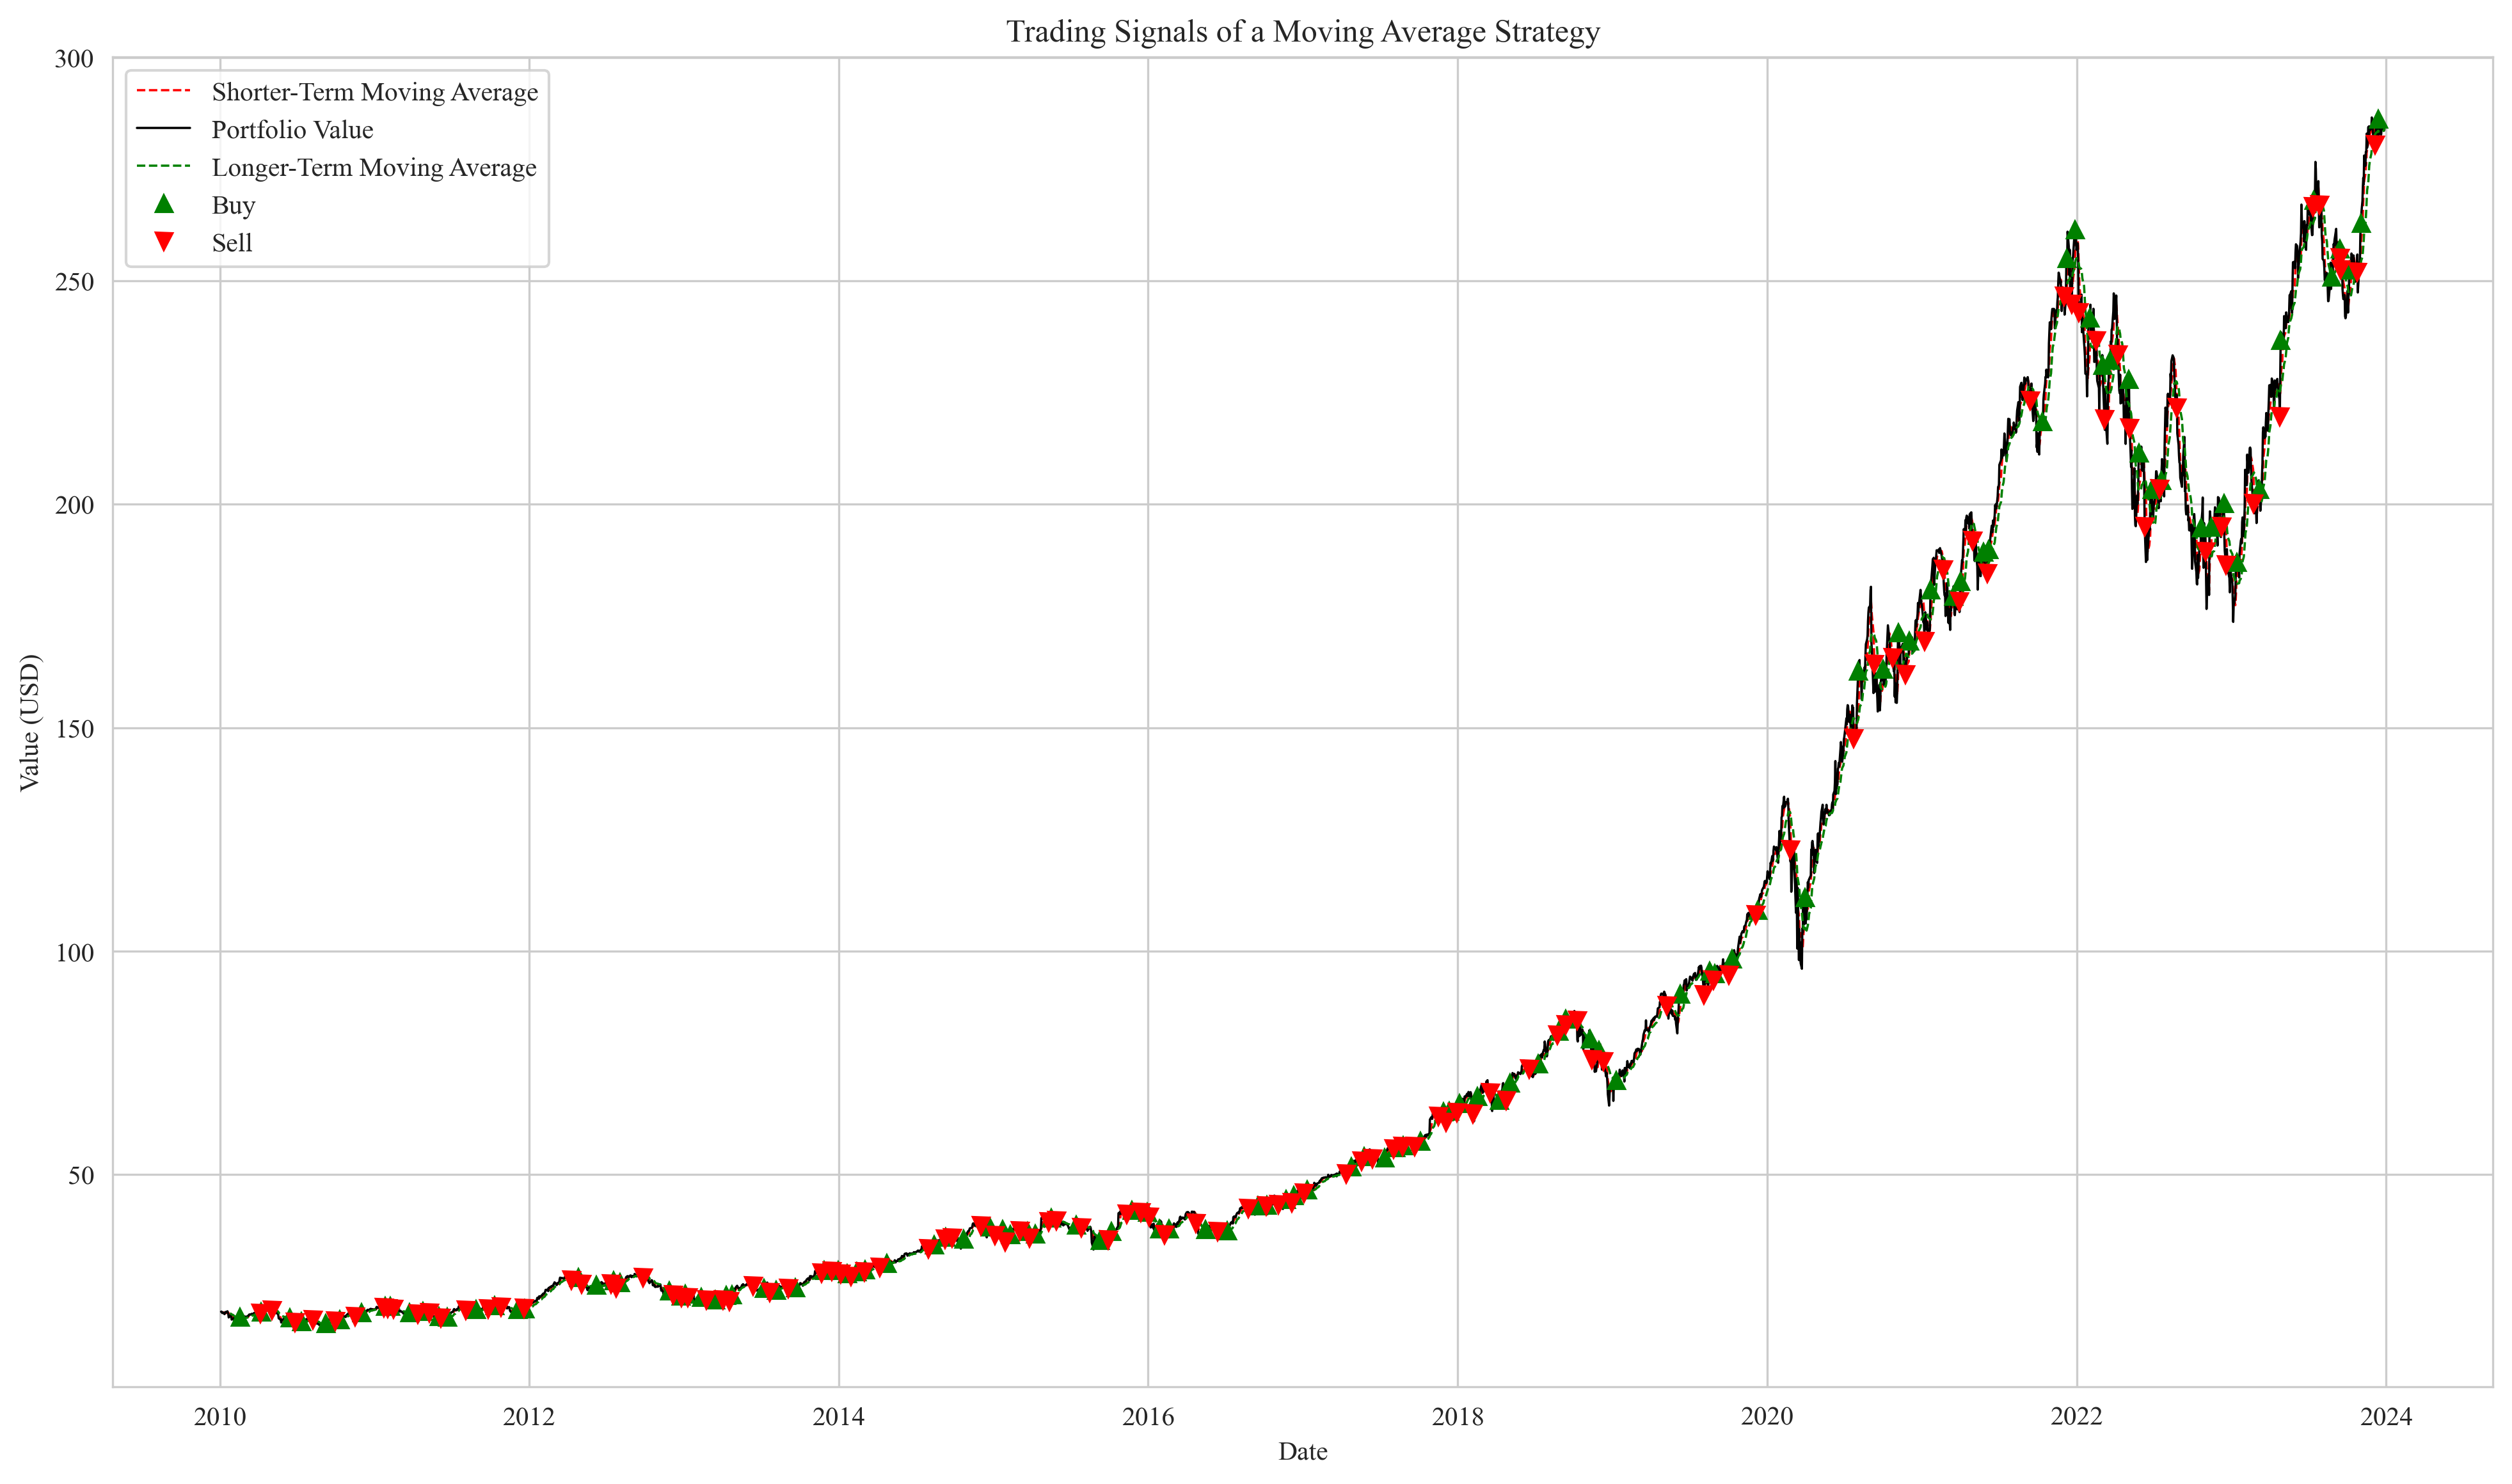

In [98]:
fig = strategy_trading_signals(strategy_name, df)        

#### **Strategy Metrics**

In [99]:
mtbl = strategy_metrics(strategy_name, df)
mtbl

,Strategy Name,Expected Return,Volatility,Sharpe Ratio,Maximum Drawdown,1-period 99% Value-at-Risk,1-period 99% Expected Shortfall,Date Range
0,Buy-and-Hold,0.000879,0.015168,0.057977,40.888543,11.975889,16.656108,2010-01-04 ----- 2023-12-29
1,Moving Average,0.001221,0.015170,0.080520,25.416414,36.554606,53.705473,2010-01-04 ----- 2023-12-29


#### **Strategy Backtest**

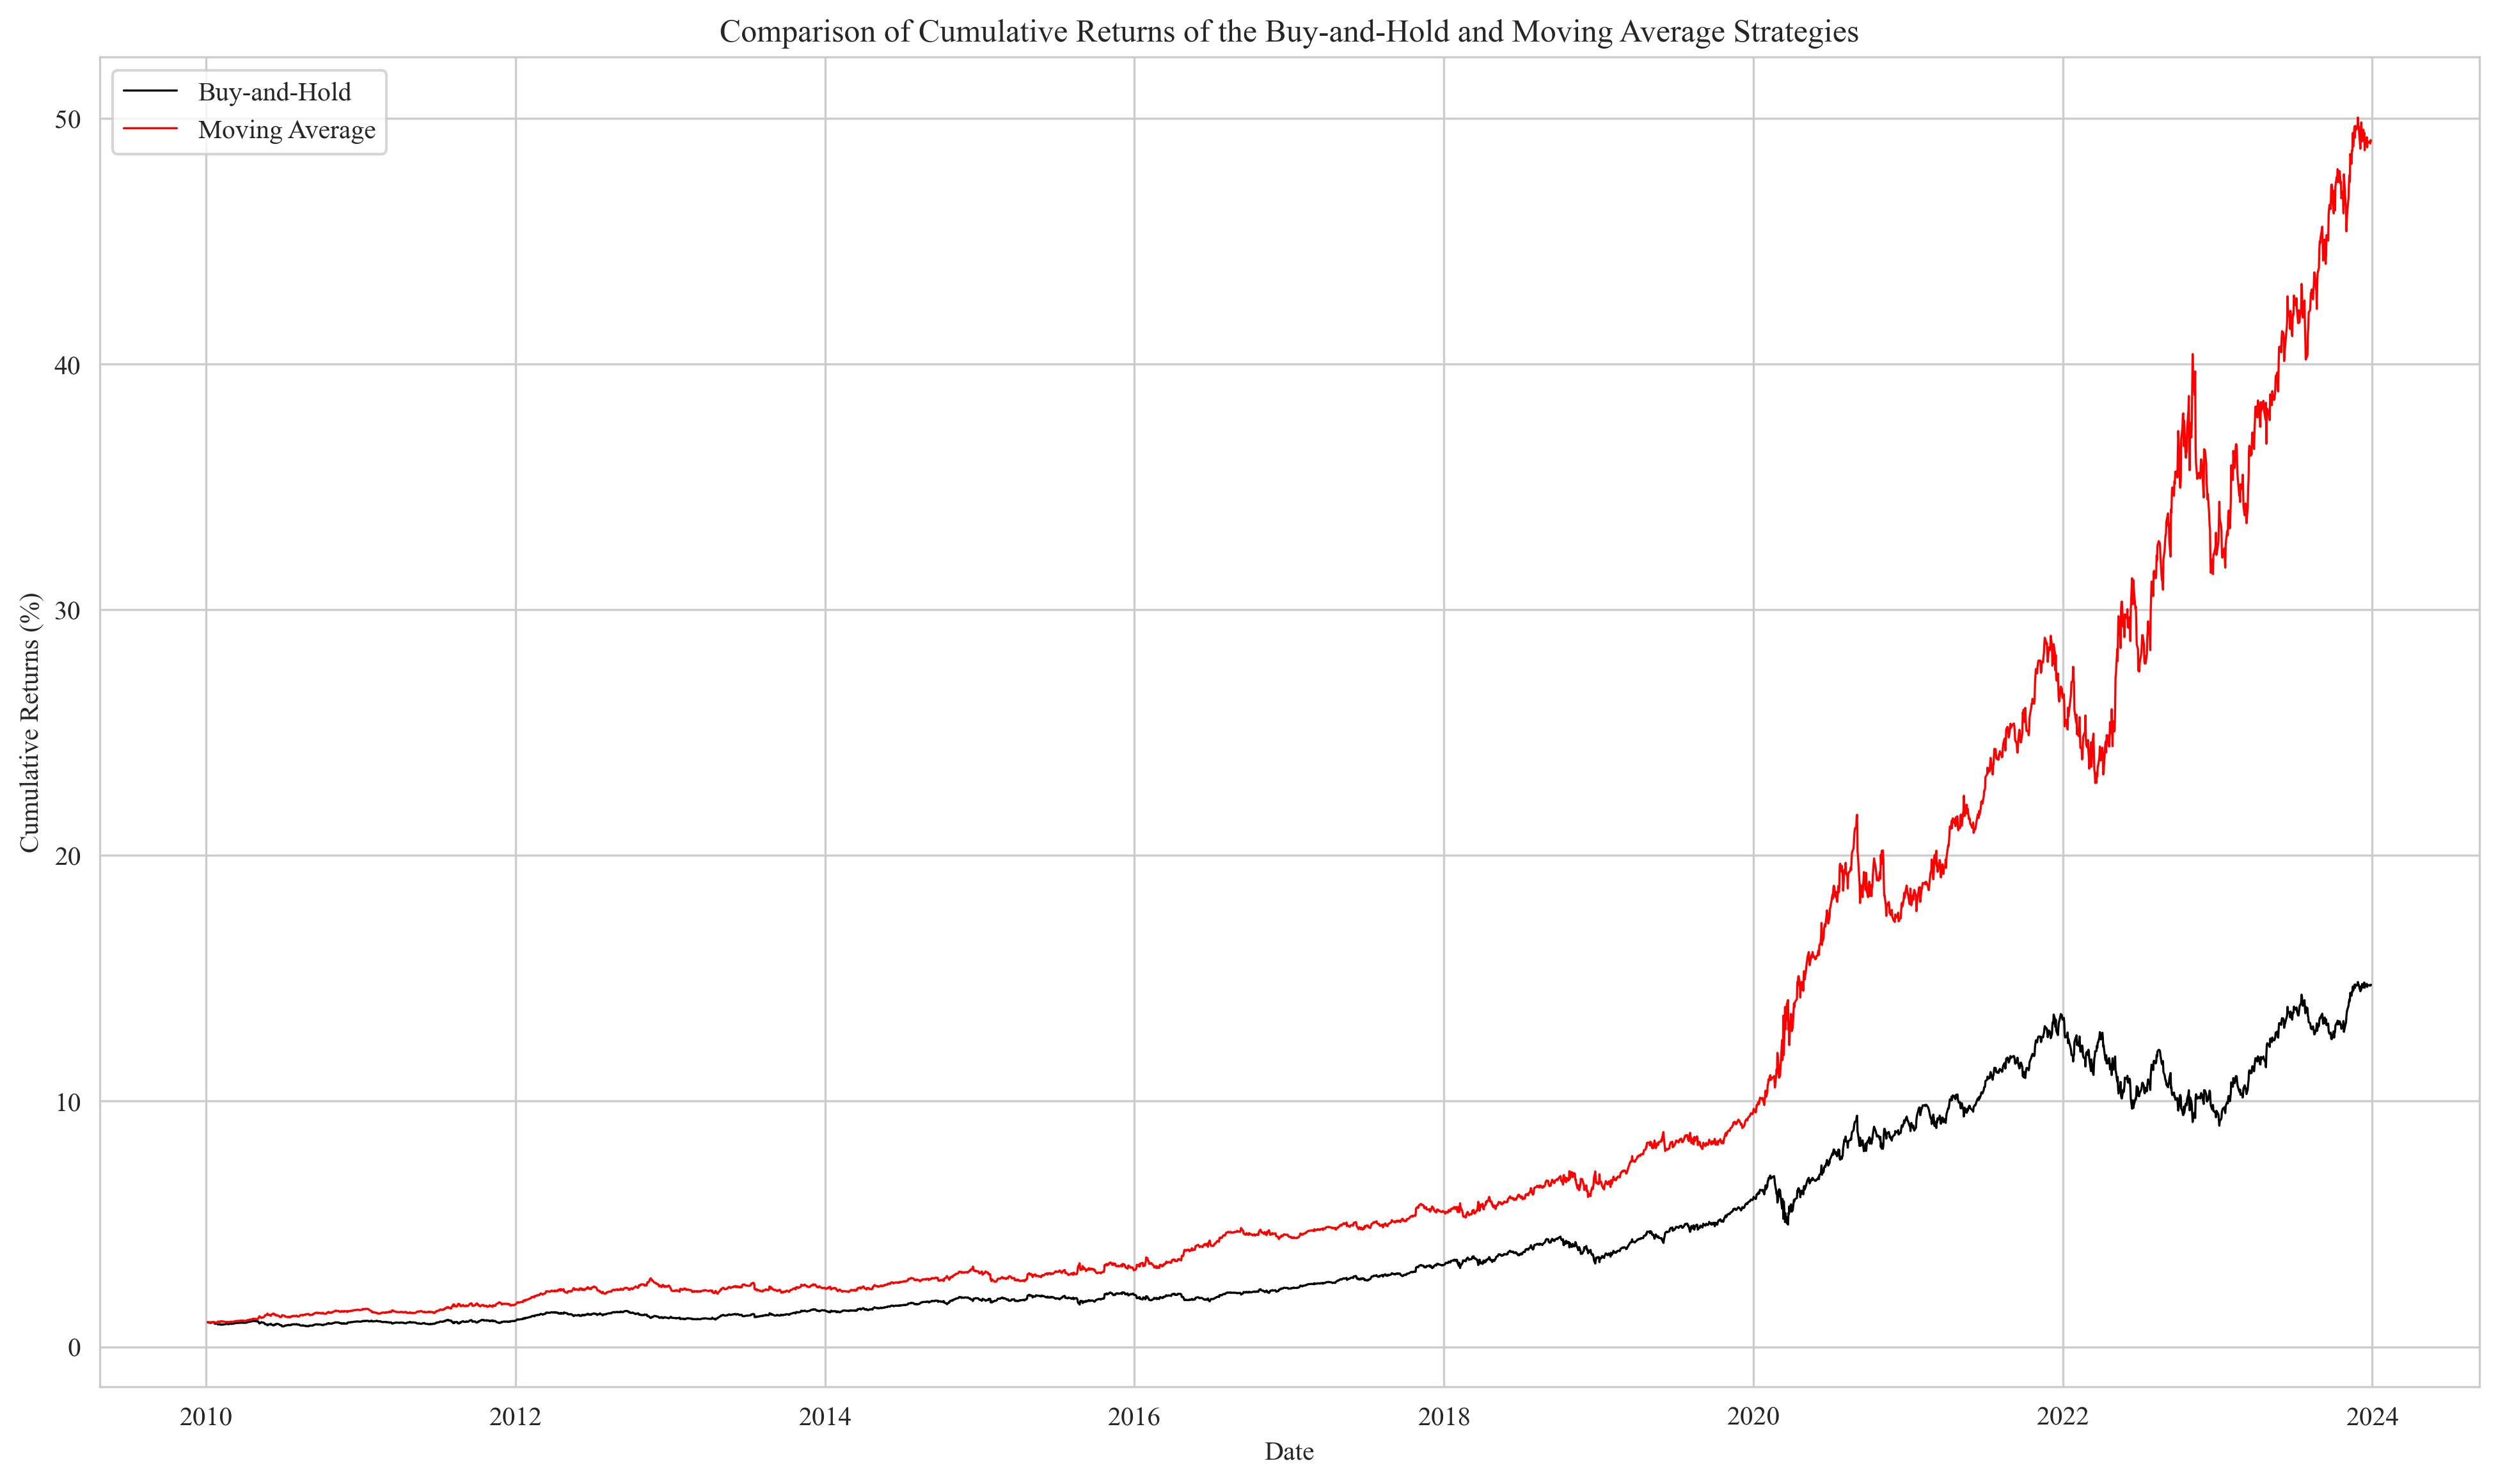

In [100]:
fig = strategy_backtest(strategy_name, df)
plt.show()

## **Bollinger Bands Strategy (WORK IN PROGRESS)**
### **Definition**
The Bollinger bands strategy is a trading strategy that executes trades according to whether the price of a financial asset is disproportionately high or low, when compared to its typical behaviour over a specific lookback window. The thresholds used to determine disproportionate price levels are called the Bollinger bands and they are defined as follows:
- *Upper Bollinger Band*: The moving average of the asset price over the specified lookback window, plus twice the moving standard deviation of the asset price over the specified lookback window;
- *Middle Bollinger Band*: The moving average of the asset price over the specified lookback window, and;
- *Lower Bollinger Band*: The moving average of the asset price over the specified lookback window, minus twice the moving standard deviation of the asset price over the specified lookback window.

The choice of multiplying the moving standard deviation by a factor of $2$ is not strictly necessary, but is nonetheless a convention inspired by the normal distribution, namely the following theorem in probability theory known as the *$3\sigma$-rule*:

$$\forall (\mu, \sigma) \in \mathbb{R} \times \mathbb{R}_{+}^{*}, \enspace X \hookrightarrow \mathsf{Normal}\left(\mu, \sigma^2\right) \implies \begin{cases}\mathbb{P}\left(\left\{\mu - \sigma \leqslant X \leqslant \mu + \sigma\right\}\right) \approx 68\% \\
\mathbb{P}\left(\left\{\mu - 2\sigma \leqslant X \leqslant \mu + 2\sigma\right\}\right) \approx 95\% \\
\mathbb{P}\left(\left\{\mu - 3\sigma \leqslant X \leqslant \mu + 3\sigma\right\}\right) \approx 99\% \\ \end{cases}$$

Although it need not always hold true that prices are normally distributed, it is often (though not always) the case that over $90\%$ of all values typically fall within about $2$ or $3$ standard deviations from the mean. The trading signals of this strategy are generated as follows:
- If the asset price exceeds the upper Bollinger band, take a short position in the asset, and;
- If the asset price falls lower than the lower Bollinger band, take a long position in the asset.

### **Python Implementation**
The Python implementation of this trading algorithm is found in the code cells below.

#### **Strategy Formulation**

In [101]:
 def bollinger_bands_strategy(tickers, start_date, end_date, lookback_window = 15, weights = None):
    """
    Generates the trading signals and performance metrics of a Bollinger bands trading strategy for a fixed lookback window.

    Parameters
    ----------
    tickers : list or numpy.ndarray
        A list of tickers for the assets in the portfolio of interest
    start_date : str
        A string representing the time frame's start date, in YYYY-MM-DD format.
    end_date : str
        A string representing the time frame's end date, in YYYY-MM-DD format.
    lookback_window : int
        An integer representing the number of periods in the lookback window.
    weights : NoneType or list or numpy.ndarray
        A list of weights with respect to which the assets are allocated in the portfolio

    Returns
    -------
    pandas.core.frame.DataFrame
        A pandas DataFrame object containing the moving average trading strategy's trading signals and performance metrics
    """
    assert 1 < lookback_window, "Lookback window must be longer than one period."
    if len(tickers) == 1:
        df = yf.download(tickers = tickers, start = start_date, end = end_date, progress = False)["Close"]
        df = pd.DataFrame({
            "Date" : df.index,
            "Portfolio" : df.values
        }).set_index("Date")
    else:
        if weights is None:
            n = len(tickers)
            weights = np.ones(n) / n
        else:
            assert len(tickers) == len(weights), "There must be as many assets as weights"
            assert sum(weights) == 1, "The portfolio must be capital budgeted, meaning that all weights must sum up to 1"
        df = yf.download(tickers = tickers, start = start_date, end = end_date, progress = False)["Close"]
        df["Portfolio"] = np.dot(weights, df.T)
        df["Middle Band"] = df["Portfolio"].rolling(lookback_window).mean()
        df["Upper Band"] = df["Middle Band"] + 2 * df["Portfolio"].rolling(lookback_window).std()
        df["Lower Band"] = df["Middle Band"] - 2 * df["Portfolio"].rolling(lookback_window).std()
        df["Signal"] = 0
        df.loc[df["Portfolio"] > df["Upper Band"], "Signal"] = -1
        df.loc[df["Portfolio"] < df["Lower Band"], "Signal"] = 1
        df["Position"] = df["Signal"].diff()
        df["Portfolio Arithmetic Returns"] = df["Portfolio"].pct_change()
        df["Portfolio Log-Returns"] = np.log(df["Portfolio"]).diff()
        df["Portfolio Cumulative Returns"] = np.exp(df["Portfolio Log-Returns"]).cumprod()
        df["Portfolio 1-period 99% Value-at-Risk"] = (np.exp(rsk.VaR_Hist(X = df["Portfolio Log-Returns"], alpha = 0.01)) - 1) * df["Portfolio"]
        df["Portfolio 1-period 99% Expected Shortfall"] = (np.exp(rsk.CVaR_Hist(X = df["Portfolio Log-Returns"], alpha = 0.01)) - 1) * df["Portfolio"]
        # WORK IN PROGRESS
        # Portfolio Rebalancing Segment
        # df["Month"] = df.groupby(df.index.to_period('M')).ngroup() + 1
        # df["Month-Change"] = df["Month"].diff()
        df["Strategy Log-Returns"] = df["Signal"] * df["Portfolio Log-Returns"]
        df["Strategy Cumulative Returns"] = np.exp(df["Strategy Log-Returns"]).cumprod()
        df["Strategy Portfolio"] = df["Portfolio"][0] * df["Strategy Cumulative Returns"]
        df["Strategy Arithmetic Returns"] = df["Strategy Portfolio"].pct_change()
        df["Strategy 1-period 99% Value-at-Risk"] = (np.exp(rsk.VaR_Hist(X = df["Strategy Log-Returns"], alpha = 0.01)) - 1) * df["Strategy Portfolio"]
        df["Strategy 1-period 99% Expected Shortfall"] = (np.exp(rsk.CVaR_Hist(X = df["Strategy Log-Returns"], alpha = 0.01)) - 1) * df["Strategy Portfolio"]
        return "Bollinger Bands", df

strategy_name, df = bollinger_bands_strategy(["AAPL", "MSFT"], "2010-01-01", "2024-01-01")
df

Ticker,AAPL,MSFT,Portfolio,Middle Band,Upper Band,Lower Band,Signal,Position,Portfolio Arithmetic Returns,Portfolio Log-Returns,Portfolio Cumulative Returns,Portfolio 1-period 99% Value-at-Risk,Portfolio 1-period 99% Expected Shortfall,Strategy Log-Returns,Strategy Cumulative Returns,Strategy Portfolio,Strategy Arithmetic Returns,Strategy 1-period 99% Value-at-Risk,Strategy 1-period 99% Expected Shortfall
Date,,,,,,,,,,,,,,,,,,,
2010-01-04,7.643214,30.950001,19.296607,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.812896,1.130578,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,7.656429,30.959999,19.308214,NaN,NaN,NaN,0,0.0,0.000601,0.000601,1.000601,0.813385,1.131258,0.0,1.000000,19.296607,NaN,0.702695,1.055413
2010-01-06,7.534643,30.770000,19.152322,NaN,NaN,NaN,0,0.0,-0.008074,-0.008107,0.992523,0.806817,1.122124,-0.0,1.000000,19.296607,0.0,0.702695,1.055413
2010-01-07,7.520714,30.450001,18.985357,NaN,NaN,NaN,0,0.0,-0.008718,-0.008756,0.983870,0.799784,1.112342,-0.0,1.000000,19.296607,0.0,0.702695,1.055413
2010-01-08,7.570714,30.660000,19.115357,NaN,NaN,NaN,0,0.0,0.006847,0.006824,0.990607,0.805260,1.119959,0.0,1.000000,19.296607,0.0,0.702695,1.055413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,193.600006,374.579987,284.089996,283.320668,286.947152,279.694183,0,0.0,-0.000070,-0.000070,14.722277,11.967674,16.644683,-0.0,0.001615,0.031165,0.0,0.001135,0.001705
2023-12-26,193.050003,374.660004,283.855003,283.625334,286.485728,280.764941,0,0.0,-0.000827,-0.000828,14.710099,11.957775,16.630915,-0.0,0.001615,0.031165,0.0,0.001135,0.001705
2023-12-27,193.149994,374.070007,283.610001,283.668001,286.505502,280.830500,0,0.0,-0.000863,-0.000863,14.697402,11.947454,16.616560,-0.0,0.001615,0.031165,0.0,0.001135,0.001705


#### **Strategy Trading Signals**

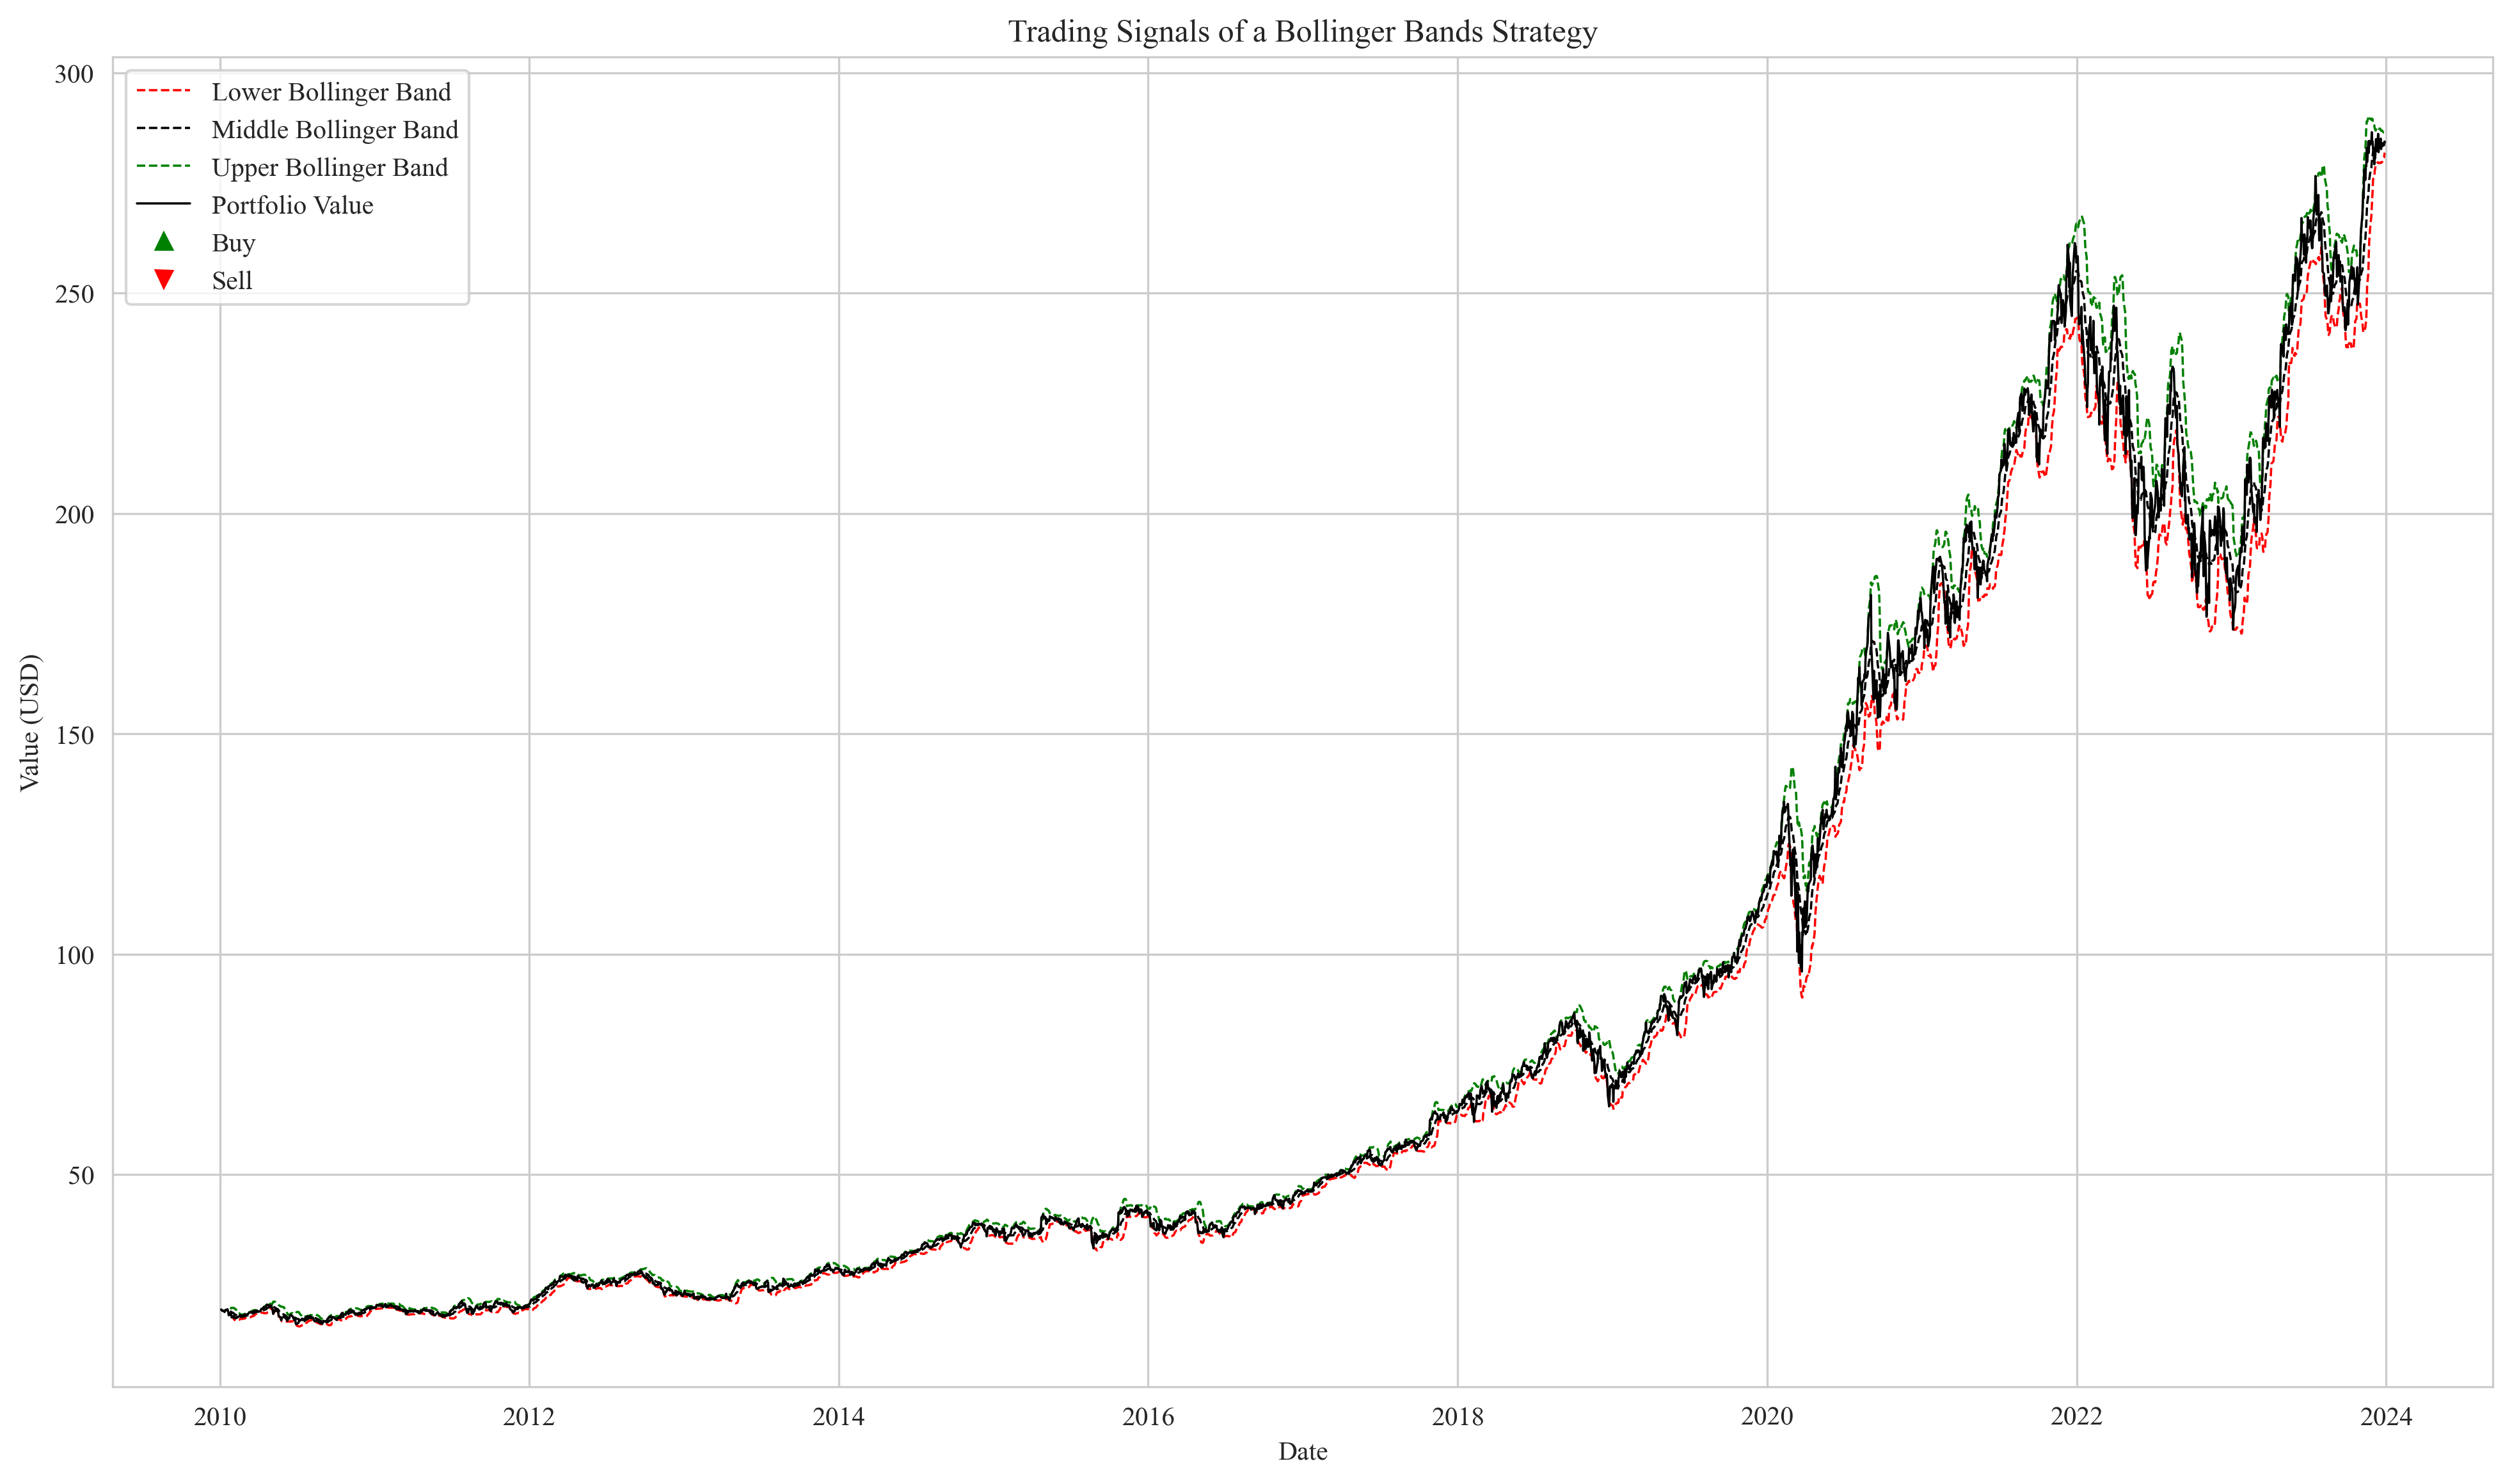

In [102]:
fig = strategy_trading_signals(strategy_name, df)

#### **Strategy Metrics**

In [103]:
mtbl = strategy_metrics(strategy_name, df)
mtbl

,Strategy Name,Expected Return,Volatility,Sharpe Ratio,Maximum Drawdown,1-period 99% Value-at-Risk,1-period 99% Expected Shortfall,Date Range
0,Buy-and-Hold,0.000879,0.015168,0.057977,40.888543,11.975889,16.656108,2010-01-04 ----- 2023-12-29
1,Bollinger Bands,-0.001797,0.007317,-0.245588,642.840377,0.001135,0.001705,2010-01-04 ----- 2023-12-29


#### **Strategy Backtest**

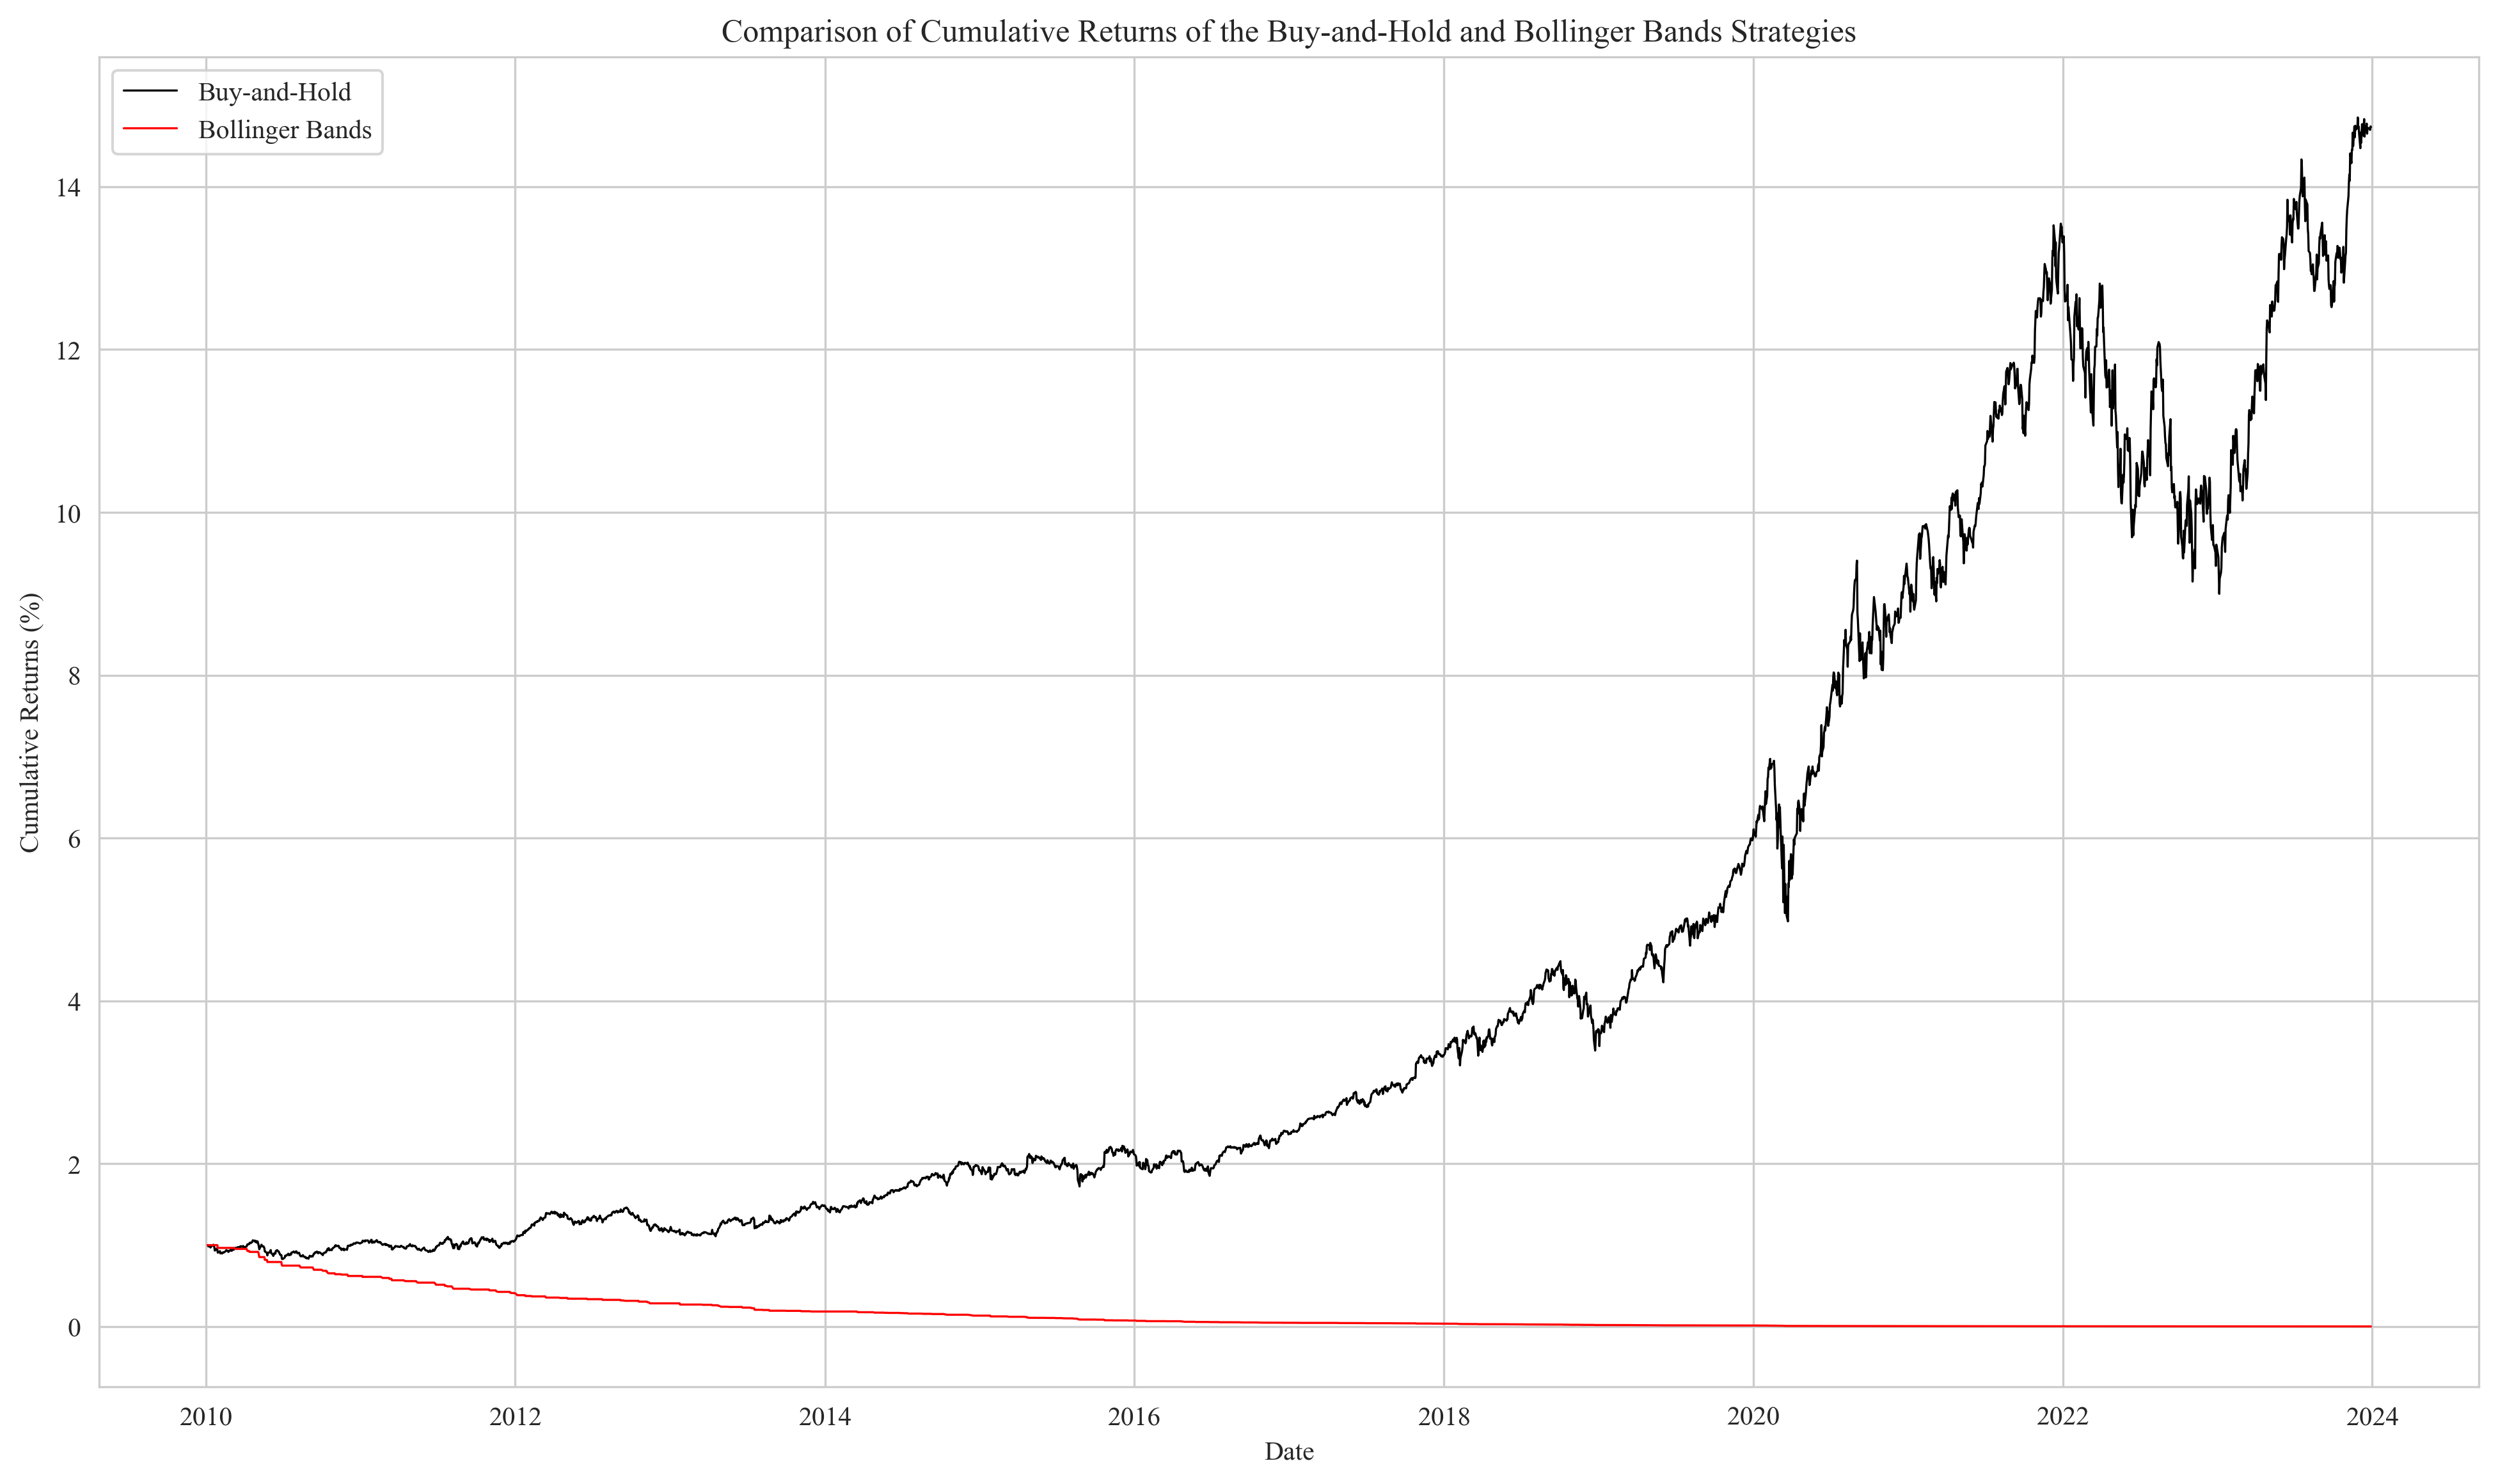

In [104]:
fig = strategy_backtest(strategy_name, df)
plt.show()

## **Credits**
1) [Chainika Thakar - *Moving Average Trading Strategies: Triple Crossover, Ribbon, and Convergence Divergence Explained*](https://blog.quantinsti.com/moving-average-trading-strategies/)
2) [Chainika Thakar and Rekhit Pachanekar - *Bollinger Bands Explained: Trading Strategy, Formula, Calculation and More*](https://blog.quantinsti.com/bollinger-bands/)
3) [QuantInsti - *Fibonacci Retracement: Trading Strategy, Python implementation, and more*](https://blog.quantinsti.com/fibonacci-retracement-trading-strategy-python/)
4) [Matt Macarty - *Introduction to Algorithmic Trading Using Python - How to Create & Test Trading Algorithm*](https://www.youtube.com/watch?v=fqltiq5EahU)
5) The original code is provided as-is in this project by Zakaria Zerrouki 